# Importing Libraries

In [1]:
# Importing the necessary packages
import numpy as np
import pandas as pd
import time
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib as mpl
mpl.rcParams.update({'font.size': 14})
import seaborn as sns

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Qiskit Imports
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel

import warnings

warnings.filterwarnings('ignore')

# Data

In [3]:
df_train= pd.read_csv('Data/glitch_trn_data.csv').reset_index()
df_trn_labels= pd.read_csv('Data/glitch_trn_class_labels.csv', names=[ 'did' , 'glitch label']).reset_index()

### Counting by category:

In [4]:
# Conteo de categorias dentro de los conjuntos de categorias
df_split = pd.DataFrame(df_trn_labels['glitch label'].value_counts()).reset_index()
df_split

,glitch label,count
0,Blip,1587
1,Koi_Fish,638
2,Low_Frequency_Burst,474
3,Low_Frequency_Lines,445
4,Power_Line,405
5,Extremely_Loud,403
6,Scattered_Light,384
7,Light_Modulation,360
8,Helix,243
9,Scratchy,242


### Most relevant categories:

In [5]:
# Solo se conservan las categorias mas relevantes
df = pd.merge(df_train, df_trn_labels, how = 'inner', on = 'index')
df_new = df[df['glitch label'].isin(['Low_Frequency_Burst','Koi_Fish'])]
df_new

,index,id,GPStime,centralFreq,peakFreq,snr,ifo,bandwidth,duration,did,glitch label
5,5,KJXiJjU9R5,1.128233e+09,809.473,99.067,203.265,H1,1554.946655,1.813,d6,Koi_Fish
10,10,iH9g1mcRF7,1.135743e+09,3127.799,10.501,10.166,L1,6243.312012,2.000,d11,Low_Frequency_Burst
27,27,x6TpjfsGOM,1.127094e+09,364.822,65.684,100.766,H1,665.643311,1.625,d28,Koi_Fish
30,30,QmppwHJrf1,1.130006e+09,2885.440,13.013,13.563,L1,5758.594727,4.000,d31,Low_Frequency_Burst
32,32,OFpetH6sLO,1.134463e+09,14.194,10.501,15.233,L1,16.102200,2.250,d33,Low_Frequency_Burst
...,...,...,...,...,...,...,...,...,...,...,...
5989,5989,IPh58Ma7Ch,1.133054e+09,3557.828,137.711,105.741,L1,7079.754883,1.250,d5990,Koi_Fish
5991,5991,rAULKM5bmR,1.133233e+09,3112.852,170.654,66.429,H1,6209.698242,2.750,d5992,Koi_Fish
5992,5992,cGWowD5ol0,1.132288e+09,229.842,72.366,84.028,H1,436.306030,2.000,d5993,Koi_Fish
5996,5996,xjlVdOZ87t,1.135179e+09,2434.358,10.501,12.226,L1,4856.431641,2.750,d5997,Low_Frequency_Burst


In [6]:
# Asignar 0 a 'Koi Fish' y 1 a 'Blip', el resto se mantiene igual
df_new['glitch label'] = df_new['glitch label'].map({'Low_Frequency_Burst': 0, 'Koi_Fish': 1})

# Mostrar el DataFrame resultante
print(df_new[['glitch label']])

      glitch label
5                1
10               0
27               1
30               0
32               0
...            ...
5989             1
5991             1
5992             1
5996             0
5999             0

[1112 rows x 1 columns]


In [7]:
# De aqui en adelante, se trabajara con el df_train
df_train = df_new

# Data exploration

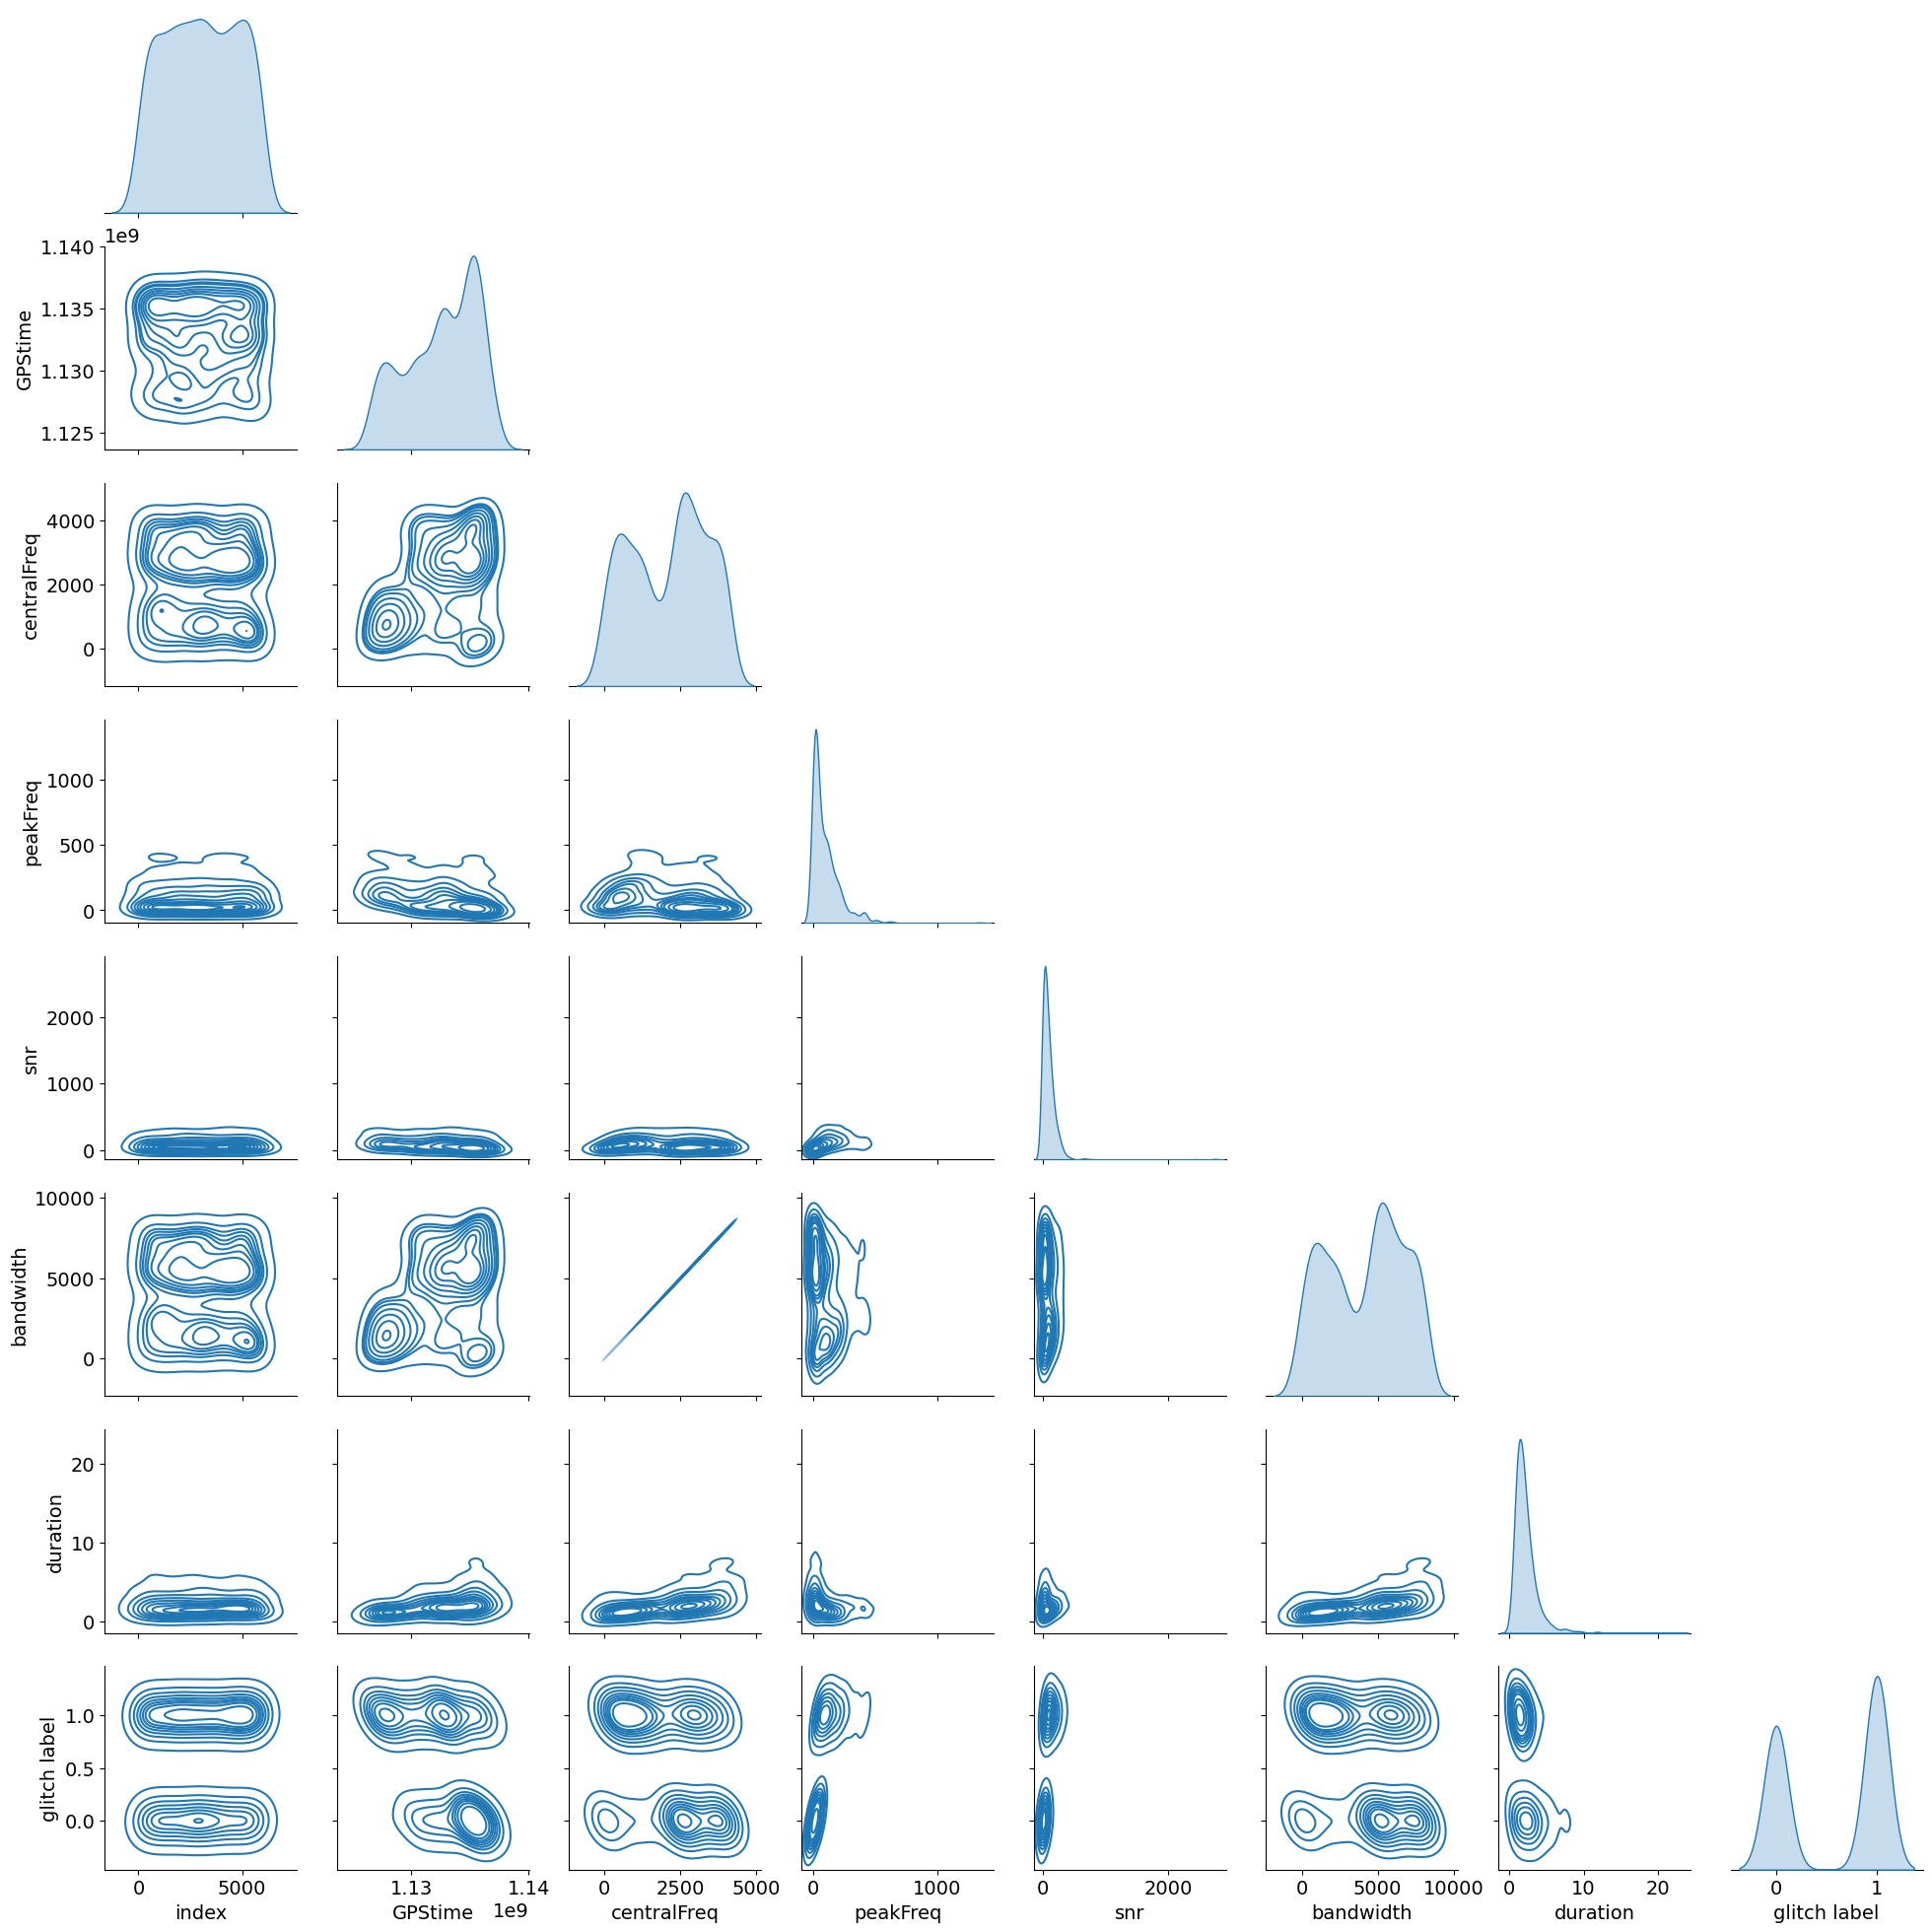

In [10]:
# Show a correlation scatter plot on the train data
import seaborn as sns
sns.pairplot(df_train, kind="kde" , corner=True)

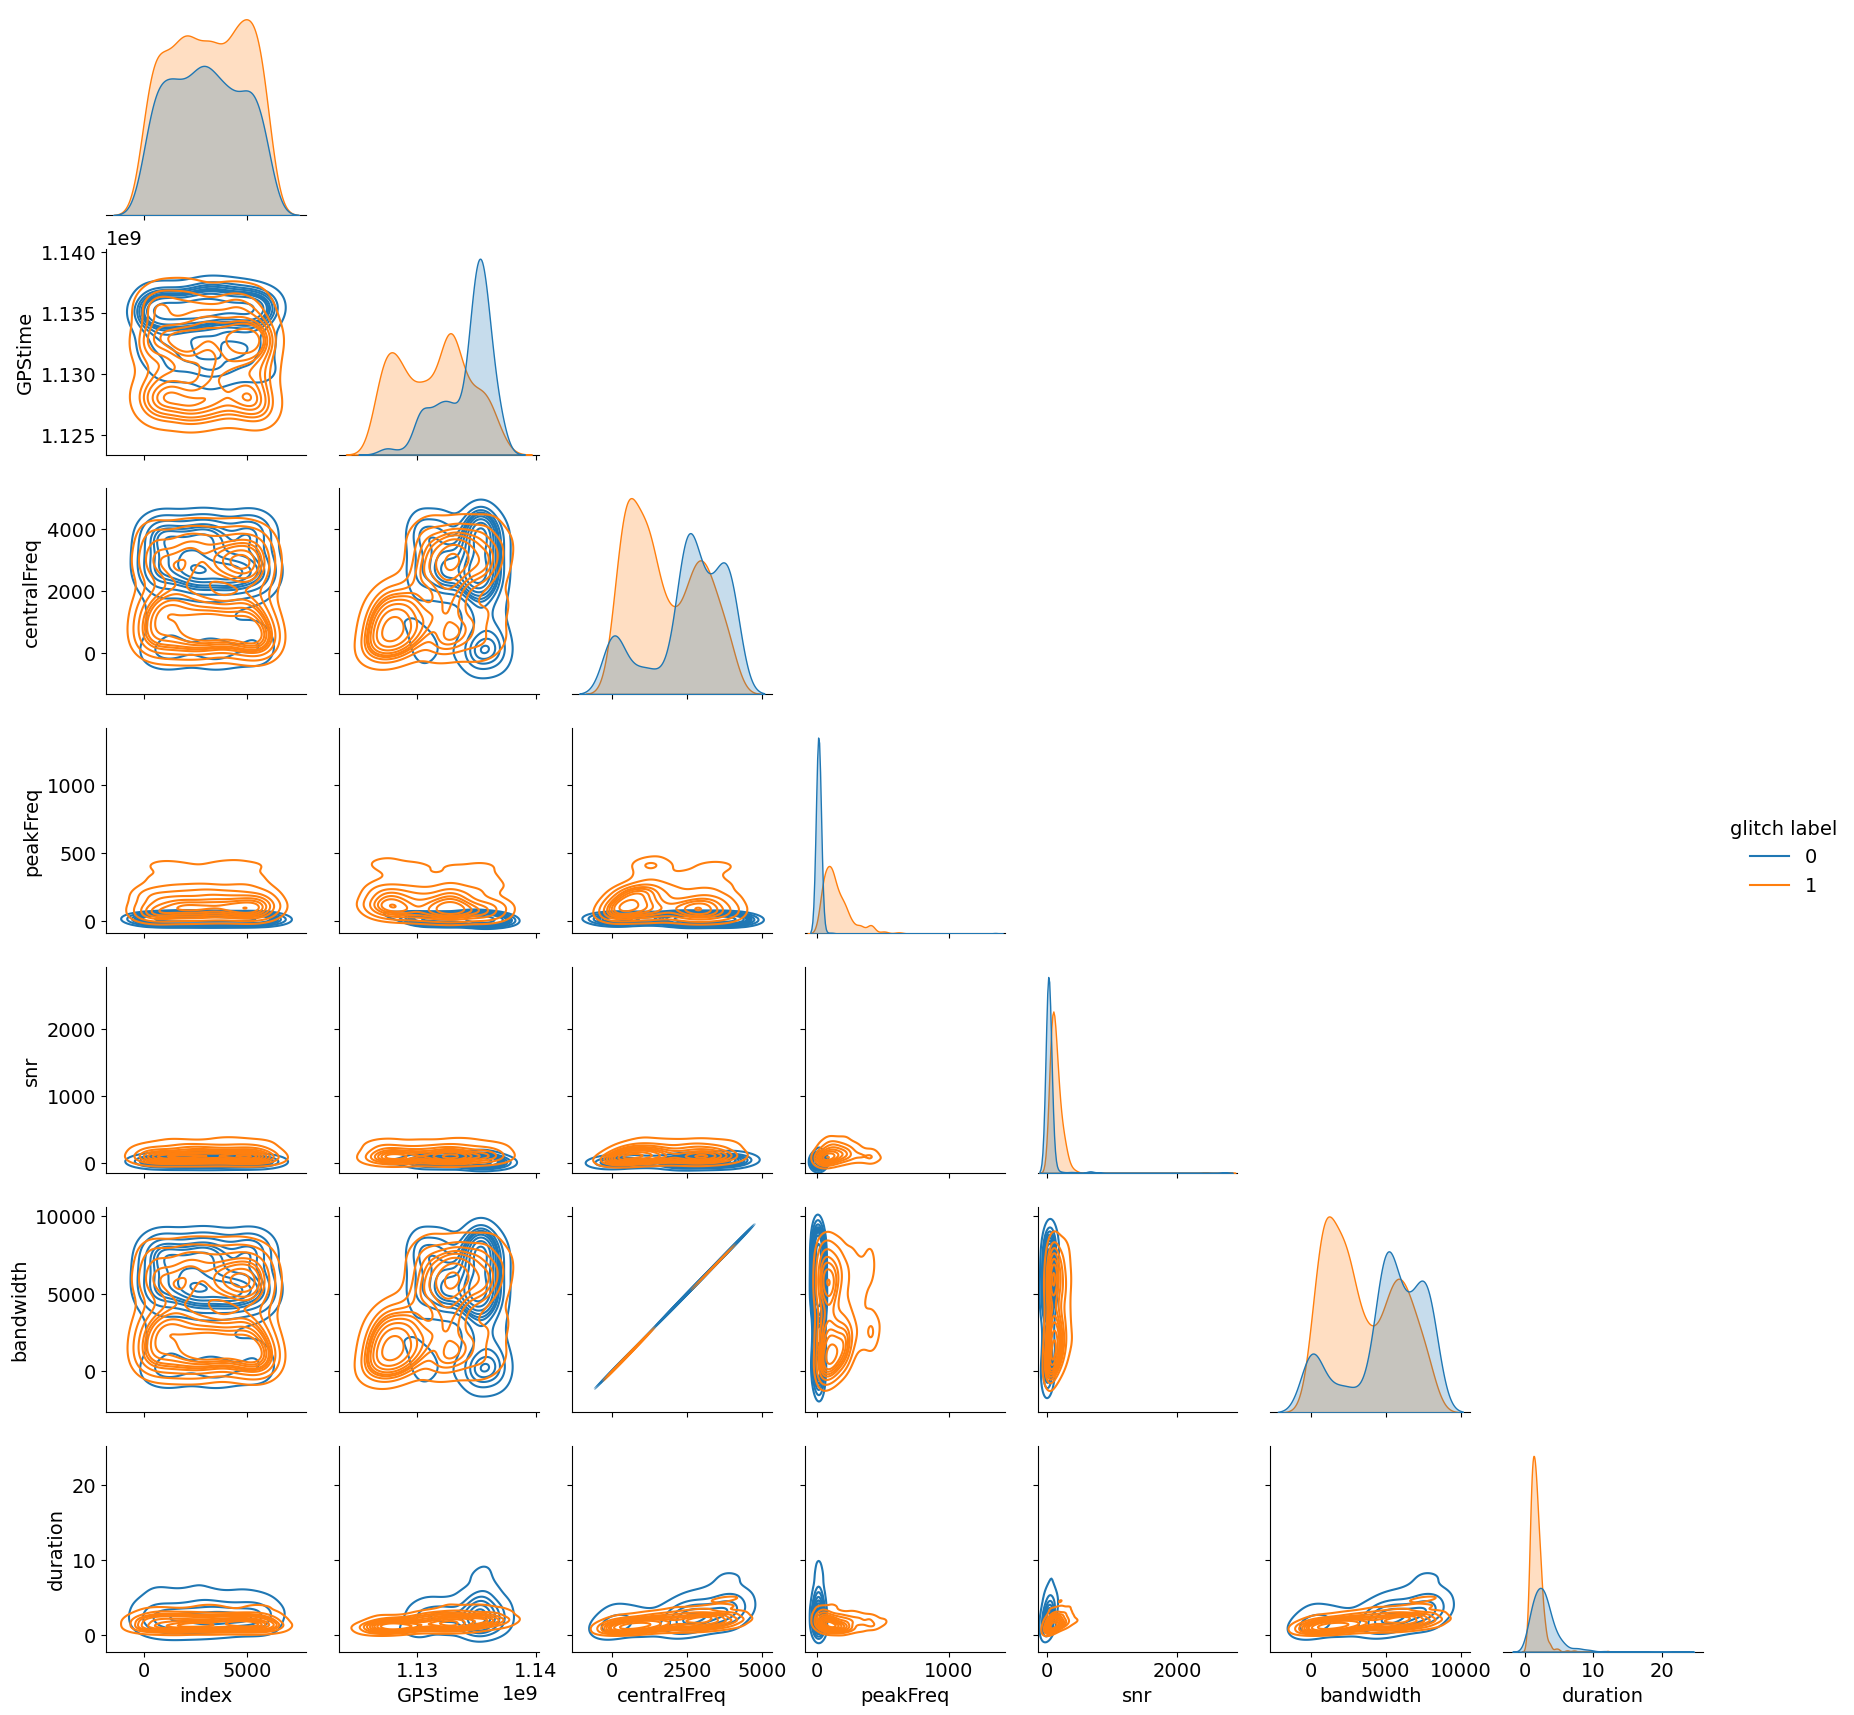

In [11]:
import seaborn as sns
sns.pairplot(df_train, kind="kde" , corner=True, hue = 'glitch label')

# Eliminación de Outliers

In [12]:
# Funcion para eliminar los outliers
def cleaner(df, columna):
    media_peakFreq = df[columna].mean()
    std_peakFreq = df[columna].std()
    umbral = 3*std_peakFreq
    df_clean = df[(df[columna] >= (media_peakFreq-umbral)) & (df[columna] <= (media_peakFreq+umbral))]
    return df_clean

In [13]:
# Limpieza de outliers, de aquellos campos con valores mas extremos
df_train_clean_peak = cleaner(df_train, 'peakFreq')
df_train_clean_snr = cleaner(df_train_clean_peak, 'snr')
df_train_clean_duration = cleaner(df_train_clean_snr, 'duration')

<Axes: xlabel='duration', ylabel='Density'>

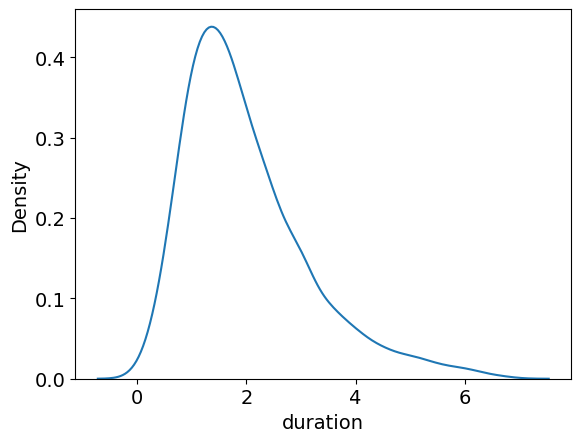

In [14]:
# Analisis de las distribuciones, luego de eliminar los outliers
sns.kdeplot(data=df_train_clean_duration, x='duration')#, hue="glitch label", fill=True, common_norm=False)

<Axes: xlabel='snr', ylabel='Density'>

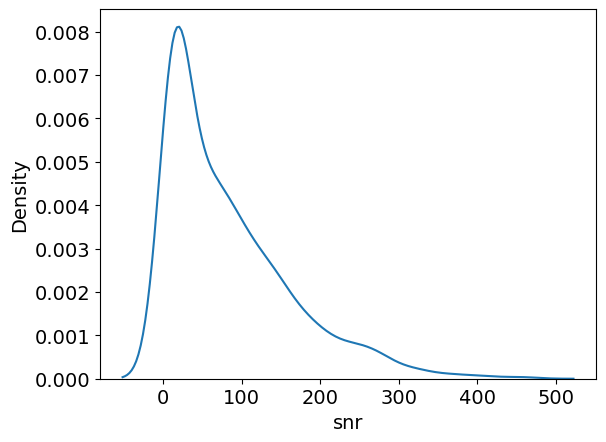

In [15]:
# Analisis de las distribuciones, luego de eliminar los outliers
sns.kdeplot(data=df_train_clean_duration, x='snr')#, hue="glitch label", fill=True, common_norm=False)

<Axes: xlabel='peakFreq', ylabel='Density'>

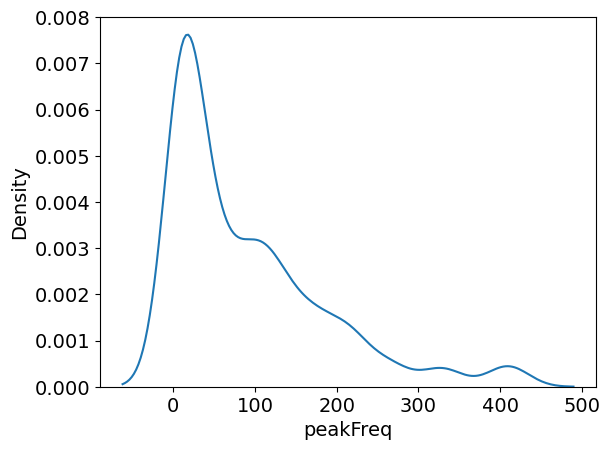

In [16]:
# Analisis de las distribuciones, luego de eliminar los outliers
sns.kdeplot(data=df_train_clean_duration, x='peakFreq')#, hue="glitch label", fill=True, common_norm=False)

# Category selection

Since not all features may be necessary to train our model, we explore: peakFreq, snr, centralFreq , bandwith, duration.

In [45]:
#selecting useful columns in the test set:
X = df_train_clean_duration[["peakFreq","snr","centralFreq","duration", "bandwidth"]]
#X['ifo'] = X['ifo'].astype('category')
Y = df_train_clean_duration['glitch label'].astype('category')

# Split training and test sets

In [55]:
#Split the train data further into train and test sets
# Split training and test sets
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.2, shuffle = True)

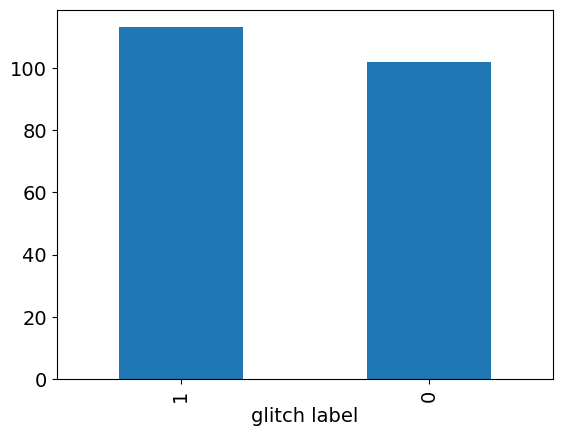

In [56]:
# Distribucion de las categorias
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
Y_test.value_counts().plot(kind="bar")
plt.savefig("glitch distribution.png", bbox_inches='tight', facecolor='w')

# Training model function

In [57]:
# Training routine
def train_model(XT, YT, Xt, Yt, model, **params):

    clf = model(**params)
    clf.fit(XT,YT)
    predictions = clf.predict(Xt)
    acc_train, acc_test = accuracy_score(YT, clf.predict(XT)), accuracy_score(Yt, predictions)
    print("Train accuracy: {:.2f}, Test accuracy: {:.2f}".format(acc_train, acc_test))
    return acc_train ,acc_test

# Data scaling

In [58]:
def transform(data):    
    std_scale = StandardScaler()
    data = std_scale.fit_transform(data)
    
    minmax_scale = MinMaxScaler((-np.pi, np.pi))
    
    return data

# Model Training

In [59]:
X_train = transform(X_train)
X_test = transform(X_test)

In [60]:
# defining parameter range
parameters = {"kernel":(['rbf']), 
              'C': [0.1, 1, 10, 100, 1000],
              'gamma':[1, 0.1, 0.001, 0.0001]}
svc = SVC() 
grid = GridSearchCV(svc, parameters, verbose=3, n_jobs=-1)

In [61]:
# Classical fit
inicio = time.time()

grid.fit(X_train, Y_train)

fin = time.time()
print(f'Tiempo de ejecucion: {fin-inicio}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tiempo de ejecucion: 0.5380270481109619


# Classic Results

In [62]:
# print best parameter after tuning
grid.best_params_

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

In [63]:
train_model(X_train, Y_train, X_test, Y_test, SVC, C= grid.best_params_['C'], kernel = grid.best_params_['kernel'], gamma = grid.best_params_['gamma'])

Train accuracy: 0.99, Test accuracy: 0.99


(0.9929988331388565, 0.9906976744186047)

# Quantum implementation

In [87]:
# Define feature maps
map_ZZ = ZZFeatureMap(feature_dimension=5, reps=3)
map_Z = ZFeatureMap(feature_dimension=5, reps=2)
map_Y = PauliFeatureMap(5, reps=3, paulis=['Y'])
map_X = PauliFeatureMap(5, reps=2, paulis=['X'])


Y_kernel = QuantumKernel(feature_map=map_Y, quantum_instance=Aer.get_backend('statevector_simulator'))
X_kernel = QuantumKernel(feature_map=map_X, quantum_instance=Aer.get_backend('statevector_simulator'))
Z_kernel = QuantumKernel(feature_map=map_Z, quantum_instance=Aer.get_backend('statevector_simulator'))
ZZ_kernel = QuantumKernel(feature_map=map_ZZ, quantum_instance=Aer.get_backend('statevector_simulator'))

In [92]:
svcq = SVC(kernel=X_kernel.evaluate)
parametersq = {"C" : np.linspace(0.1, 1, 10, 100, 1000)}

clfq = GridSearchCV(svcq, parametersq, n_jobs = -1)

In [93]:
inicio = time.time()

clfq.fit(X_train, Y_train)

fin = time.time()
print(f'Tiempo de ejecucion: {fin-inicio}')

Tiempo de ejecucion: 85.28489279747009


# Quantum Results

In [94]:
q_pred = clfq.predict(X_test)
print(clfq.best_params_)
accuracy_score(Y_test, q_pred)

{'C': 0.1}


0.9674418604651163

In [95]:
q_pred = clfq.predict(X_train)
print(clfq.best_params_)
accuracy_score(Y_train, q_pred)

{'C': 0.1}


0.9603267211201867